In [1]:
import torch 
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Implementing VGG19 model

In [2]:
vgg =  models.vgg19(pretrained=True).features

for param in vgg.parameters():
    param.requires_grad_(False)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [4]:
def load_image(img_patch, max_size=800, shape=None):
    """Function to loading images

    Args:
        img_patch ([int]): Image Path
        max_size ([int]): Control the size of the images
        shape ([int]): Style image always takes shape of content image
    """
    
    image = Image.open(img_patch).convert('RGB')   # Open image in RGB standard
    
    if max(image.size)>max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
    
    in_transform = transforms.Compose([
            transforms.Resize(size),
            transforms.ToTensor(),
            transforms.Normalize((0.5), (0.5))]) 
    image = in_transform(image).unsqueeze(0)
    return image

In [5]:
content = load_image('Images\Images\Asia1.jpg').to(device)
style = load_image('Images\Images\StarryNight.jpg', shape = content.shape[-2:]).to(device)

In [6]:

def im_convert(tensor):
  """Converts tensor to numpy image

  Args:
      tensor ([tensor]): Tensor image
  Returns:
      [Numpy Image]: Numpy image
  """
  image = tensor.cpu().clone().detach().numpy()
  image = image.squeeze()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

(-0.5, 799.5, 996.5, -0.5)

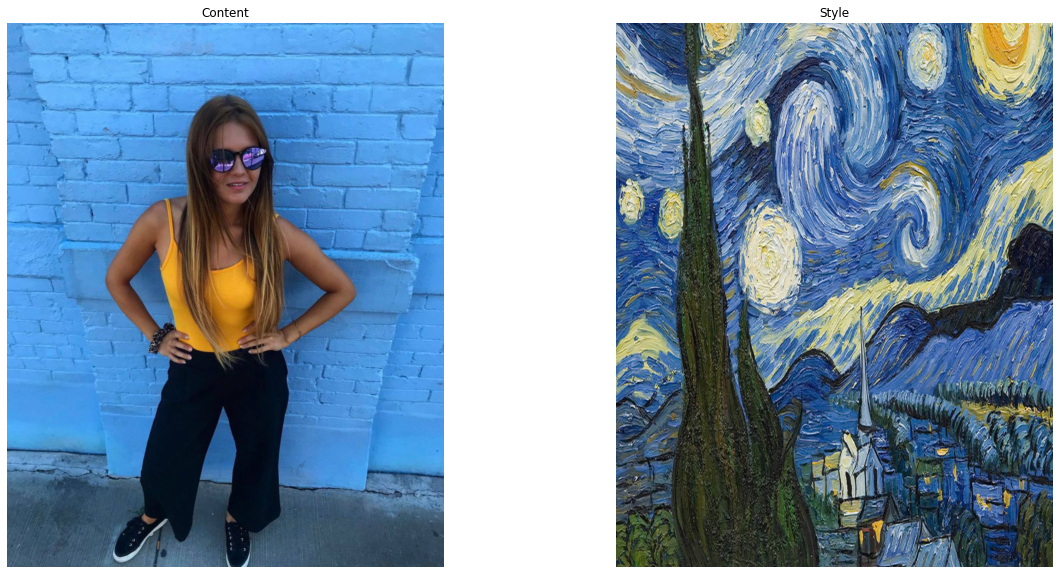

In [7]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,10))

ax1.imshow(im_convert(content))
ax1.title.set_text("Content")
ax1.axis('off')

ax2.imshow(im_convert(style))
ax2.title.set_text("Style")
ax2.axis('off')

# Implementing Style Transfer 

In [8]:
def get_features(image, model):
    """[Function to get featrues of the image]

    Args:
        image ([Tensor Image]): Image to extract features off
        model ([nn.Model]): Model to extract features
    """
    
    layers = {'0': 'conv1_1',
              '5': 'conv2_1',
              '10': 'conv3_1',
              '19': 'conv4_1',
              '21': 'conv4_2',                  
              '28': 'conv5_1'}
    features = {}
    
    for name, layer in model._modules.items():  # name contain number of layer 
        image = layer(image)
        if name in  layers:
            features[layers[name]] = image
    return features

In [9]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

C:\Users\01133904\Anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


# Gram Matrix

In [10]:
def gram_matrix(tensor):
    _, d, h, w =  tensor.size()
    tensor = tensor.view(d, h*w)
    gram = torch.mm(tensor, tensor.t())
    return gram

In [11]:
style_grams ={layer: gram_matrix(style_features[layer]) for layer in style_features}

In [12]:
style_weights = {'conv1_1':1.,
                 'conv2_1':0.75,
                 'conv3_1':0.2,
                 'conv4_1':0.2,
                 'conv5_1':0.2}

content_weight = 1 
style_weight = 1e6   # play with it 

In [13]:
target = content.clone().requires_grad_(True).to(device)

In [14]:
show_every = 300                            #Update image every 300 iterations
optimizer = optim.Adam([target], lr=0.003)
steps = 2400
height, width, channels = im_convert(target).shape

image_array = np.empty(shape = (300,height, width, channels))
capture_frame = steps/300
counter = 0


Iteration:  300
Total loss:  5385404.0


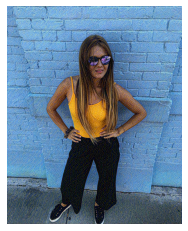

Iteration:  600
Total loss:  1429305.125


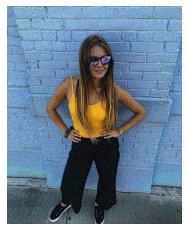

Iteration:  900
Total loss:  812446.25


Iteration:  1200
Total loss:  563125.25


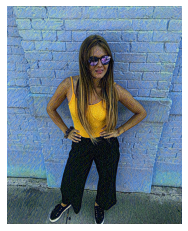

Iteration:  1500
Total loss:  416497.125


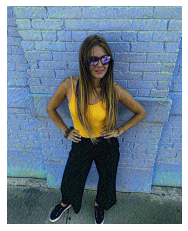

Iteration:  1800
Total loss:  314873.9375


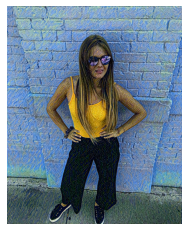

Iteration:  2100
Total loss:  240548.3125


Iteration:  2400
Total loss:  186415.609375


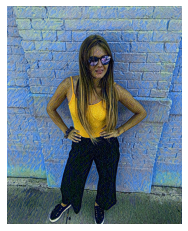

In [15]:
losses = [] 

for ii in range(1,steps+1):
    
    target_features = get_features(target, vgg)
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    style_loss = 0
    
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] *torch.mean((target_gram - style_gram)**2)
        _, d, h, w =target_feature.shape
        style_loss += layer_style_loss / (d * h * w) 
              
    total_loss = content_loss*content_weight + style_loss*style_weight
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if ii % show_every == 0:
        print("Iteration: ", ii)
        print("Total loss: ", total_loss.item())
        plt.imshow(im_convert(target))
        plt.axis('off')
        plt.show()
        losses.append(total_loss.item())
        
    if ii % capture_frame == 0:
        image_array[counter] = im_convert(target)
        counter = counter + 1
        

     

Text(0.5, 1.0, 'Loss')

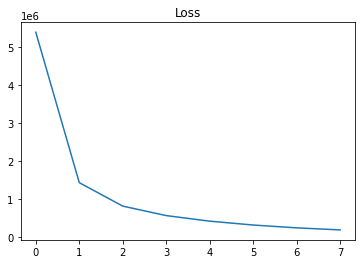

In [16]:
plt.plot(range(len(losses)),losses)
plt.title("Loss")

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(im_convert(content))
ax1.title.set_text("Content")
ax1.axis('off') 

ax2.imshow(im_convert(style))
ax2.title.set_text("Style")
ax2.axis('off')

ax3.imshow(im_convert(target))
ax3.title.set_text("Result")
ax3.axis('off')

(-0.5, 799.5, 996.5, -0.5)

# Creation of an mp4 video showing style changes

In [18]:
import cv2 
 
frame_height, frame_width, _ = im_convert(target).shape
vid = cv2.VideoWriter('output.mp4', cv2.VideoWriter_fourcc(*'XVID'), 30, (frame_width, frame_height))
 
for i in range(0, 300):
  img = image_array[i]
  img = img*255
  img = np.array(img, dtype = np.uint8)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  vid.write(img)
 
vid.release()